In [84]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate
from scipy.integrate import cumtrapz

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)
    
from tools.e5tools import *
from orographicConvectionTheory.orographicConvectionTheory import *
from orographicPrecipitation.observationsAndERA5.mountainUtils import *
from orographicPrecipitation.precip_model_functions import qsat
km_per_degreelat = 6370*np.pi/180
mnths=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']


import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

xr.set_options(display_style='text') 

In [6]:
import dask
from dask.distributed import Client
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
client=Client(n_workers=8,memory_limit="35GB")

# Functions

In [156]:
def compute_primes(region,varname,month=-1):
    if 'level' in region.vars_rot[varname].dims:
        varL = crossslope_avg(region.vars_rot[varname]).sel(level=slice(700.,900.)).mean('level')
    else:
        varL = crossslope_avg(region.vars_rot[varname])
    varLprime = (varL-varL.sel(x=slice(varL.x[0],varL.x[0]+200)).mean('x'))
    if month<0:
        return varLprime.sel(x=slice(-200,-50)).mean('x')
    else:
        return varLprime.sel(time=(varLprime['time.month']==month),x=slice(-200,-50)).mean('x')
def get_binned(a,b,bins,itq=False,bootstrap=False):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    if itq:
        bin_median = np.array([np.median(np.array(b)[digitized == i]) for i in range(1, len(bins))])
        try:
            bin_q1 = np.array([np.quantile(np.array(b)[digitized == i],0.25) for i in range(1, len(bins))])
            bin_q2 = np.array([np.quantile(np.array(b)[digitized == i],0.75) for i in range(1, len(bins))])
        except IndexError:
            bin_q1 = bin_median
            bin_q2 = bin_median
        return bin_centers,bin_means,bin_median,bin_q1,bin_q2
    elif bootstrap :
        cinf_csup =  np.array([bootstrap_CI_mean(np.array(b)[digitized == i],95) for i in range(1, len(bins))])
        return bin_centers,bin_means,cinf_csup[:,0],cinf_csup[:,1]
    else:
        return bin_centers,bin_means

def sel_month(ds,m):
    return ds.sel(time=(ds['time.month']==m))

from scipy.optimize import curve_fit
def fit_coefs(pred,dep,model='linear'):
    predrange = np.linspace(np.min(pred),np.max(pred),41)
    if model=='linear':
        func = lambda x,a,b : a*x+b
    elif model=='exponential':
        func = lambda x,a,b : np.exp(a*x+b)
    elif model=='softplus':
        func = lambda x,a,b : np.log(1+np.exp(a*x+b))
    popt,_ = curve_fit(func,pred,dep)
    fitrange = func(predrange,*popt)
    residual = dep - func(pred,*popt)
    rss = np.sum(residual**2)
    tss = len(dep)*np.var(dep)
    rsq = 1-rss/tss
    return predrange,fitrange,rsq,popt

def sel_summer(var):
    return var.sel(time = ((var['time.month']>=7)&(var['time.month']<=9)))

In [2]:
from scipy import special
def linregress_xr_2(x,y,dim='time'):
    nt = len(x[dim])
    assert nt==len(y[dim])
    ssxm = nt*x.var(dim=dim)
    ssym = nt*y.var(dim=dim)
    ssxym = nt*xr.cov(x,y,dim=dim)       
    r = np.maximum(np.minimum(ssxym / np.sqrt(ssxm * ssym),1.),-1)
    slope = ssxym / ssxm
    
    df = nt - 2  # Number of degrees of freedom
    TINY = 1.0e-20
    t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
    
    pval = special.stdtr(df, -np.abs(t))*2 * x.isel({dim:0})**0
    
    return xr.merge([slope.rename('slope'),(r**2).rename('rsquared'),pval.rename('pvalue')])

def fdr(pvalues,alpha):
    sortidx = np.argsort(pvalues)
    psorted = pvalues[sortidx]
    psorted[np.isnan(psorted)]=1
    nval = len(pvalues)
    ifdr = np.argmax((psorted < alpha*np.arange(1,nval+1)/nval)[::-1])
    if ifdr == 0 and psorted[-1]>= alpha:
        ifdr=nval-1
    ifdr = nval - ifdr - 1
    return sortidx[:ifdr]

def fdr_xr_2d(pvalues,alpha):
    pvalues=np.array(pvalues)
    assert len(pvalues.shape)==2
    ntot = pvalues.shape[0]*pvalues.shape[1]
    idxs_1d = fdr(pvalues.reshape(-1),alpha)
    flags = np.zeros(ntot)
    flags[idxs_1d] = 1
    return flags.reshape(pvalues.shape)*pvalues**0

In [89]:
def thetae_perso(t,q,qs,p):
    """t in K, t[pname] and es in hPa, q and qs in kg/kg. returns thetae in K"""
    r  = q/(1-q)
    epsilon = 287.04/461.5
    es = qs*p/(epsilon+(1-epsilon*qs))
    rh = q/qs
    # Magnus formula for dew point
    b=18.678;c=257.14
    gamma = np.log(rh)+b*(t-275.15)/(c+(t-273.15))
    tdew = 273.15+c*gamma/(b-gamma)
    tL = 1/(1/(tdew-56)+np.log(t/tdew)/800)+56
    e = rh*es
    
    kappad=0.2854
    thetaL = t*(1e3/(p-e))**kappad*(t/tL)**(0.28*r)
    thetae = thetaL*np.exp((3036/tL-1.78)*r*(1+0.448*r))
    return thetae

def compute_BL(thetaeB,thetaeL,thetaeLstar):
    g=9.81
    wB = 0.52
    wL = 1-wB
    thetae0 = 340
    capeL   = (thetaeB/thetaeLstar - 1)*thetae0
    subsatL = (1 - thetaeL/thetaeLstar)*thetae0
    BL = g/thetae0*(wB*capeL-wL*subsatL) # Did not include the KappaL term to conform with AAN2020
    return BL

def compute_BLsimple(thetaeB,eL,eLstar,kind='deep'):
    kappaL=3
    g=9.81
    wB = 0.52
    wL = 1-wB
    if kind=='shallow':
        PiL = 0.938
    elif kind=='deep':
        PiL = 0.88
    BLsimple = g/eLstar*PiL*(wB*thetaeB+(wL*eL-eLstar)/PiL)
    return BLsimple

# Analysis

In [133]:
control_dir = "/global/cfs/cdirs/m3310/wboos/cesm2.1.3archive/cam5clm4F2kclim_ctrl/atm/hist/"
control_paths = sorted(glob.glob(control_dir+'*0[7-9]_plev.nc'))
control_monthly = xr.open_mfdataset(control_paths,combine='nested',concat_dim='time',parallel=True).rename({'lev_p':'pressure'})

control_paths_mlevs = sorted(glob.glob(control_dir+'*0[7-9].nc'))[-12:]
control_monthly_mlevs = xr.open_mfdataset(control_paths_mlevs,combine='nested',concat_dim='time',parallel=True)

In [134]:
pertsst_dir = "/global/cscratch1/sd/wboos/archive/cam5clm4F2kclim_ctrl/atm/hist/"
pertsst_paths = sorted(glob.glob(pertsst_dir+'*0[7-9]_plev.nc'))[3:]
pertsst_monthly = xr.open_mfdataset(pertsst_paths,combine='nested',concat_dim='time',parallel=True).rename({'lev_p':'pressure'})

pertsst_paths_mlevs = sorted(glob.glob(pertsst_dir+'*0[7-9].nc'))[-12:]
pertsst_monthly_mlevs = xr.open_mfdataset(pertsst_paths_mlevs,combine='nested',concat_dim='time',parallel=True)

In [135]:
box = [240,270,35,15] 
boxwide = [225,285,50,0]
control_monthly=sel_box(control_monthly,boxwide,lon='lon',lat='lat')
control_monthly_mlevs=sel_box(control_monthly_mlevs,boxwide,lon='lon',lat='lat')
pertsst_monthly=sel_box(pertsst_monthly,boxwide,lon='lon',lat='lat')
pertsst_monthly_mlevs=sel_box(pertsst_monthly_mlevs,boxwide,lon='lon',lat='lat')

In [179]:
%%time
control_qs = qsat(control_monthly.T,control_monthly.pressure)
pb = control_monthly.pressure.sel(pressure = slice(850,1000))
control_thetaeb = thetae_perso(control_monthly.T.sel(pressure = slice(850,1000)),control_monthly.Q.sel(pressure = slice(850,1000)),control_qs.sel(pressure = slice(850,1000)),pb).mean('pressure').compute()
control_TL     = control_monthly.T.sel(pressure = slice(500,850)).mean('pressure')
control_qL     = control_monthly.Q.sel(pressure = slice(500,850)).mean('pressure')
control_eL     = control_TL + 2.5e3*control_qL
control_eLstar = control_TL + 2.5e3*control_qs.sel(pressure = slice(500,850)).mean('pressure')
control_BLsimple = compute_BLsimple(control_thetaeb,control_eL,control_eLstar).load()
control_precip = ((control_monthly_mlevs.PRECC+control_monthly_mlevs.PRECL)*1000*86400).load()


CPU times: user 1.85 s, sys: 176 ms, total: 2.03 s
Wall time: 5.29 s


In [180]:
%%time
pertsst_qs = qsat(pertsst_monthly.T,pertsst_monthly.pressure)
pb = pertsst_monthly.pressure.sel(pressure = slice(850,1000))
pertsst_thetaeb = thetae_perso(pertsst_monthly.T.sel(pressure = slice(850,1000)),pertsst_monthly.Q.sel(pressure = slice(850,1000)),pertsst_qs.sel(pressure = slice(850,1000)),pb).mean('pressure').compute()
pertsst_TL     = pertsst_monthly.T.sel(pressure = slice(500,850)).mean('pressure')
pertsst_qL     = pertsst_monthly.Q.sel(pressure = slice(500,850)).mean('pressure')
pertsst_eL     = pertsst_TL + 2.5e3*pertsst_qL
pertsst_eLstar = pertsst_TL + 2.5e3*pertsst_qs.sel(pressure = slice(500,850)).mean('pressure')
pertsst_BLsimple = compute_BLsimple(pertsst_thetaeb,pertsst_eL,pertsst_eLstar).load()
pertsst_precip = ((pertsst_monthly_mlevs.PRECC+pertsst_monthly_mlevs.PRECL)*1000*86400).load()


CPU times: user 1.61 s, sys: 115 ms, total: 1.72 s
Wall time: 2.44 s


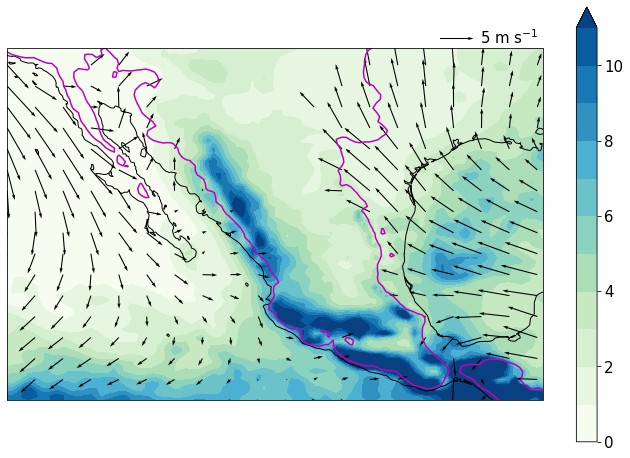

In [230]:
fig,ax = plt.subplots(1,1,figsize=(12,8),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
ax.coastlines()
sel_box(orogm,box[:2]+box[-1:-3:-1]).plot.contour(ax=ax,levels=[500.],colors='m')
sel_box(control_precip.mean('time'),box,'lon','lat').plot.contourf(ax=ax,levels=np.linspace(0,11,12),cmap=plt.cm.GnBu,cbar_kwargs={'label':''})
u = sel_box(control_UB.mean('time'),box,'lon','lat')
v = sel_box(control_VB.mean('time'),box,'lon','lat')
X = u.lat.expand_dims({"lon":u.lon}).transpose()
Y = v.lon.expand_dims({"lat":u.lat})
n=5
m=5
q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="k",width=0.002,scale=80)
ax.quiverkey(q, 0.87, 1.03, 5, r'5 m s$^{-1}$', labelpos='E',
                           coordinates='axes',color='k')


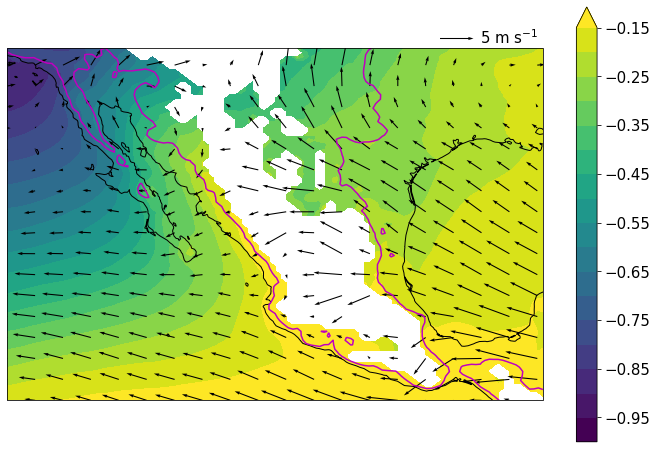

In [232]:
fig,ax = plt.subplots(1,1,figsize=(12,8),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
ax.coastlines()
sel_box(orogm,box[:2]+box[-1:-3:-1]).plot.contour(ax=ax,levels=[500.],colors='m')
sel_box(control_BLsimple.mean('time'),box,'lon','lat').plot.contourf(ax=ax,levels=np.arange(-1,-0.1,0.05),cmap=plt.cm.viridis,cbar_kwargs={'label':''})
u = sel_box(control_UL.mean('time'),box,'lon','lat')
v = sel_box(control_VL.mean('time'),box,'lon','lat')
X = u.lat.expand_dims({"lon":u.lon}).transpose()
Y = v.lon.expand_dims({"lat":u.lat})
n=5
m=5
q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="k",width=0.002,scale=80)
ax.quiverkey(q, 0.87, 1.03, 5, r'5 m s$^{-1}$', labelpos='E',
                           coordinates='axes',color='k')


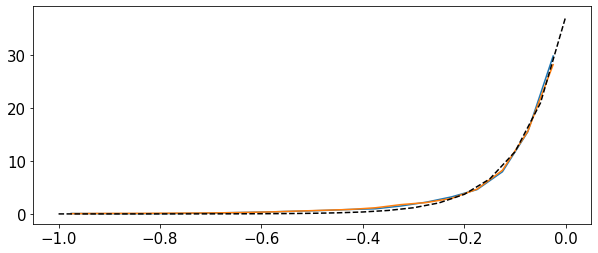

In [167]:
_,ax=plt.subplots(figsize=(10,4))
bins = np.linspace(-1,0,21)
centers,means = get_binned(np.array(control_BLsimple).reshape(-1),np.array(control_precip).reshape(-1),bins)
ax.plot(centers,means)
centers,means = get_binned(np.array(pertsst_BLsimple).reshape(-1),np.array(pertsst_precip).reshape(-1),bins)
ax.plot(centers,means)

fit_func_monthly =  lambda bl: np.exp(11.55*bl+3.62)
ax.plot(bins,fit_func_monthly(bins),color='k',linestyle='--')

In [203]:
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
control_UL     = control_monthly.U.sel(pressure = slice(700,850)).mean('pressure')
control_VL     = control_monthly.V.sel(pressure = slice(700,850)).mean('pressure')
control_UB     = control_monthly.U.sel(pressure = slice(900,1000)).mean('pressure')
control_VB     = control_monthly.V.sel(pressure = slice(900,1000)).mean('pressure')

pertsst_UL     = pertsst_monthly.U.sel(pressure = slice(700,850)).mean('pressure')
pertsst_VL     = pertsst_monthly.V.sel(pressure = slice(700,850)).mean('pressure')
pertsst_UB     = pertsst_monthly.U.sel(pressure = slice(900,1000)).mean('pressure')
pertsst_VB     = pertsst_monthly.V.sel(pressure = slice(900,1000)).mean('pressure')


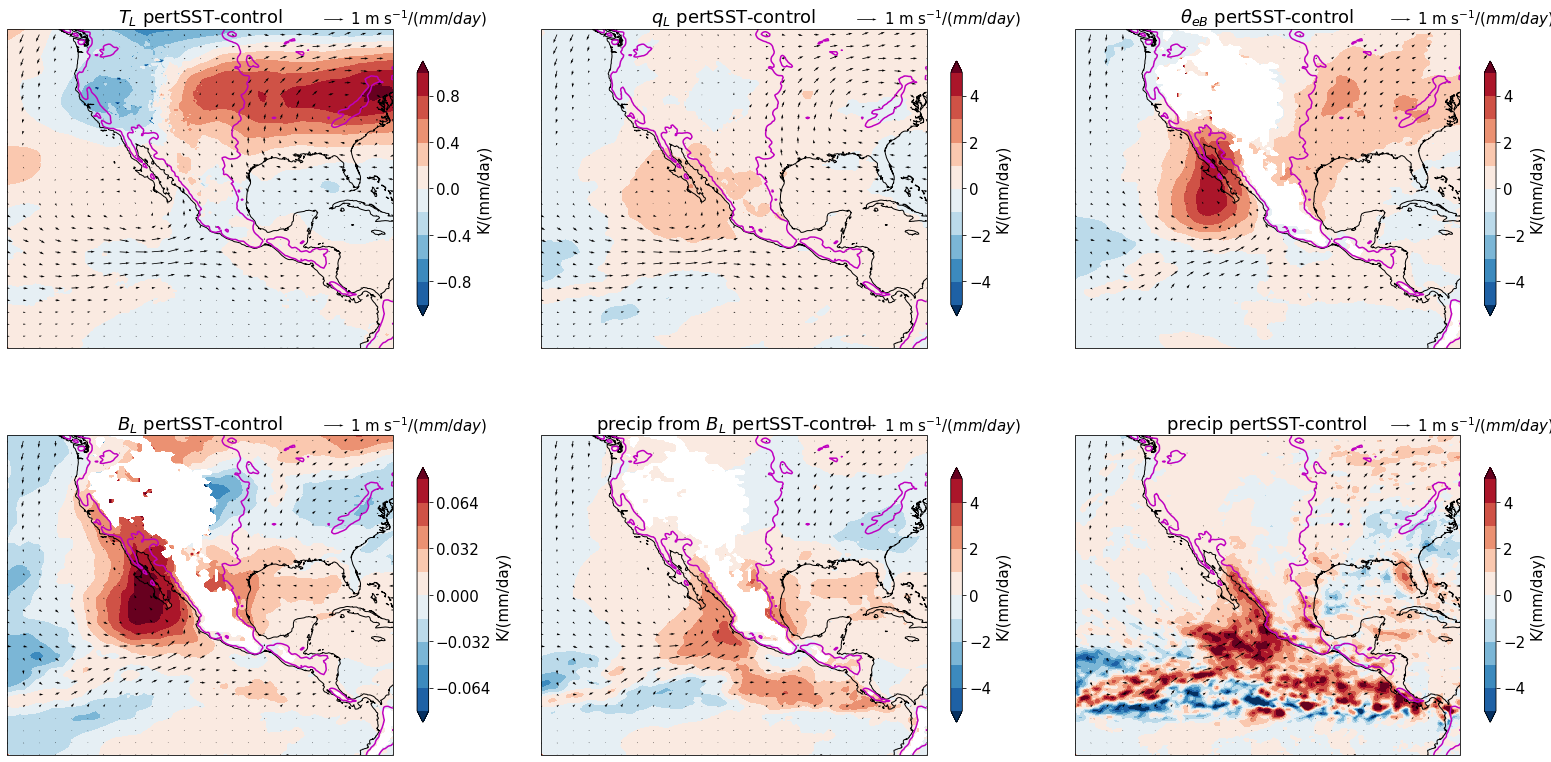

In [236]:
fig,axs = plt.subplots(2,3,figsize=(22,12),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
axs=axs.reshape(-1)
for ax in axs.reshape(-1):
    ax.coastlines()
    sel_box(orogm,boxwide[:2]+boxwide[-1:-3:-1]).plot.contour(ax=ax,levels=[500.],colors='m')

for ax,var,varname,scale in zip(axs,
                                (pertsst_TL-control_TL,2.5e3*(pertsst_qL-control_qL),pertsst_thetaeb-control_thetaeb,pertsst_BLsimple-control_BLsimple,fit_func_monthly(pertsst_BLsimple)-fit_func_monthly(control_BLsimple),pertsst_precip-control_precip),
                                (r"$T_L$",r"$q_L$",r"$\theta_{eB}$",r"$B_L$",r"precip from $B_L$","precip"),
                                (1,5,5,0.08,5,5)):
    plot = var.mean('time').load()
    plot[0,0] = scale*1.1; plot[-1,-1] = -scale*1.1
    plot.plot.contourf(ax=ax,levels=np.linspace(-scale,scale,11),cmap=plt.cm.RdBu_r,cbar_kwargs={'label':'K/(mm/day)','shrink':0.6})
    ax.set_title(varname+' pertSST-control')

for i,ax in enumerate(axs):
    if i<2:
        u = (pertsst_UL - control_UL).mean('time')
        v = (pertsst_VL - control_VL).mean('time')
    else:
        u = (pertsst_UB - control_UB).mean('time')
        v = (pertsst_VB - control_VB).mean('time')
    X = u.lat.expand_dims({"lon":u.lon}).transpose()
    Y = v.lon.expand_dims({"lat":u.lat})
    n=8
    m=8
    q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="k",width=0.002,scale=100)
    ax.quiverkey(q, 0.87, 1.03, 5, r'1 m s$^{-1}/(mm/day)$', labelpos='E',
                               coordinates='axes',color='k')

fig.tight_layout()


In [198]:
BLpert_tb = compute_BLsimple(pertsst_thetaeb,control_eL,control_eLstar).load()
prBLpert_tb = fit_func_monthly(BLpert_tb)-fit_func_monthly(control_BLsimple)
BLpert_tb = BLpert_tb - control_BLsimple

BLpert_tbqL = compute_BLsimple(pertsst_thetaeb,control_TL + 2.5e3*pertsst_qL,control_eLstar).load()
prBLpert_tbqL = fit_func_monthly(BLpert_tbqL)-fit_func_monthly(control_BLsimple)
BLpert_tbqL = BLpert_tbqL - control_BLsimple


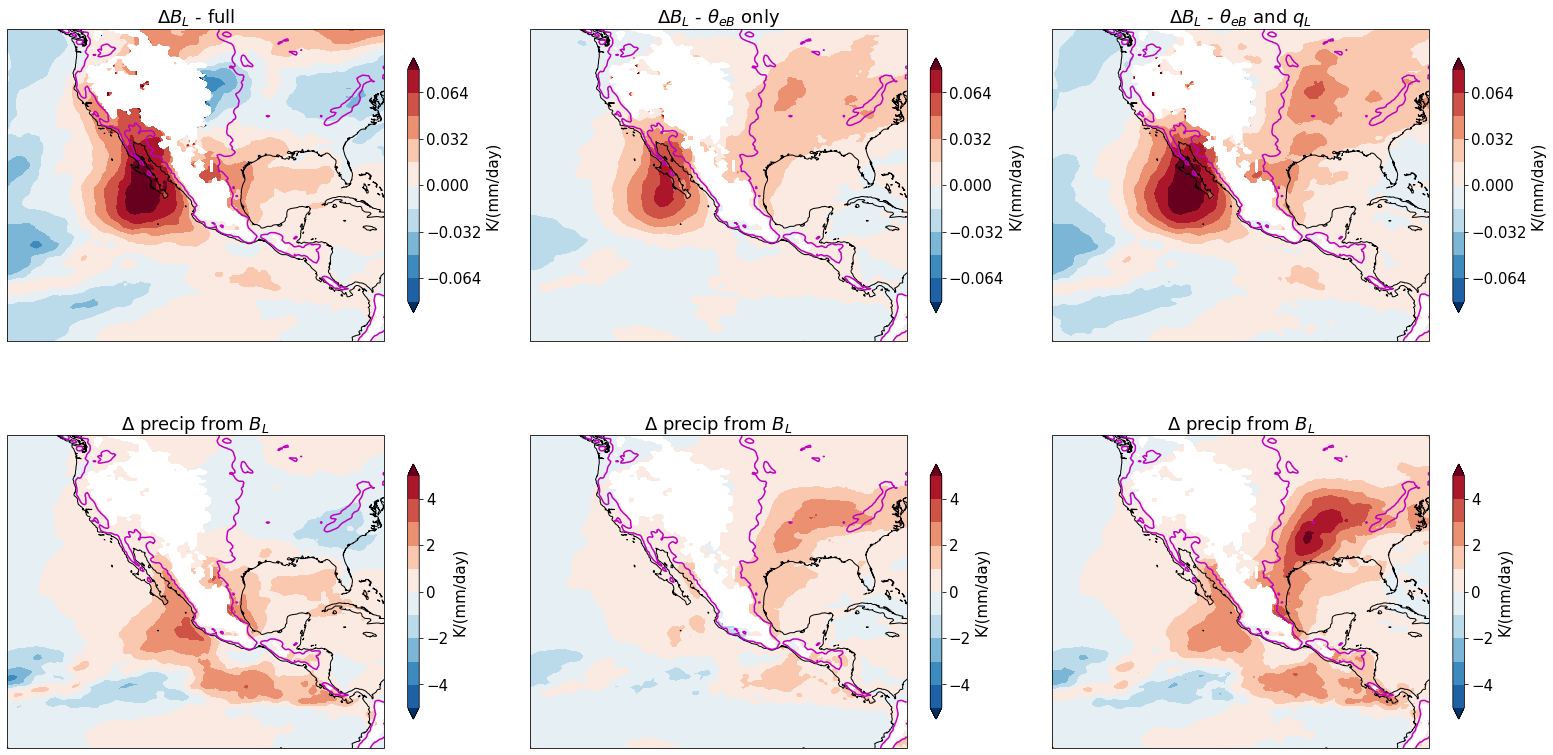

In [237]:
fig,axs = plt.subplots(2,3,figsize=(22,12),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
axs=axs.transpose().reshape(-1)
for ax in axs.reshape(-1):
    ax.coastlines()
    sel_box(orogm,boxwide[:2]+boxwide[-1:-3:-1]).plot.contour(ax=ax,levels=[500.],colors='m')

for ax,var,varname,scale in zip(axs,
                                (pertsst_BLsimple-control_BLsimple,fit_func_monthly(pertsst_BLsimple)-fit_func_monthly(control_BLsimple),BLpert_tb,prBLpert_tb,BLpert_tbqL,prBLpert_tbqL),
                                (r"$\Delta B_L$ - full",r"$\Delta$ precip from $B_L$",
                                 r"$\Delta B_L$ - $\theta_{eB}$ only",r"$\Delta$ precip from $B_L$",
                                 r"$\Delta B_L$ - $\theta_{eB}$ and $q_L$",r"$\Delta$ precip from $B_L$"),
                                (0.08,5,0.08,5,0.08,5)):
    plot = var.mean('time').load()
    plot[0,0] = scale*1.1; plot[-1,-1] = -scale*1.1
    plot.plot.contourf(ax=ax,levels=np.linspace(-scale,scale,11),cmap=plt.cm.RdBu_r,cbar_kwargs={'label':'K/(mm/day)','shrink':0.6})
    ax.set_title(varname)
fig.tight_layout()
